In [18]:
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.utils.data as Data 
import torchvision 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score,train_test_split

In [19]:
df = pd.read_csv(r"C:\Users\dyy\Desktop\12.csv")
X = np.expand_dims(df.values[:, 0:8].astype(float), axis=2)#增加一维轴
X1 = df.values[:, 0:8]
Y = df.values[:, 8:229]

In [20]:
def minmaxscaler(df):
    min = np.amin(df)
    max = np.amax(df)    
    return (df - min)/(max-min)

def fan_minmaxscaler(x,df):
    min = np.amin(df)
    max = np.amax(df)    
    return x*(max-min)+ min

In [21]:

def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    # 计算分子，协方差————按照协方差公式，本来要除以n的，由于在相关系数中上下同时约去了n，于是可以不除以n
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    # 计算分母，方差乘积————方差本来也要除以n，在相关系数中上下同时约去了n，于是可以不除以n
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))
 
    corr_factor = cov_ab/sq
 
    return corr_factor


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split( minmaxscaler(X),  minmaxscaler(Y), test_size=0.2, random_state=5)

In [23]:
x_tra = Variable(torch.from_numpy(X_train))
x_tra = x_tra.float()
x_tes = Variable(torch.from_numpy(X_test))
x_tes = x_tes.float()
y_tra = Variable(torch.from_numpy(Y_train))
y_tra = y_tra.float()
y_tes = Variable(torch.from_numpy(Y_test))
y_tes = y_tes.float()
x_tra = x_tra.permute(0,2,1)
x_tes = x_tes.permute(0,2,1)

In [24]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1  = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 1, 
                out_channels = 16,
                kernel_size = 2
            ),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 16, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(1)
        )
        self.conv2  = torch.nn.Sequential(
            torch.nn.Conv1d(16, 64, 2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 64, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(1)
        )
        self.conv3  = torch.nn.Sequential(
            torch.nn.Conv1d(64, 128, 2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 128, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(1)
        )
        self.conv4  =torch.nn.Sequential(
            torch.nn.Conv1d(128, 64, 2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 64, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(1)
        )
        self.e0 = nn.Flatten()
        self.mlp2  =torch.nn.Sequential(
            torch.nn.Linear(256,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,221)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)

        x = self.e0(x)
        x = self.mlp2(x)
        return x

In [26]:
model = CNN()
loss_func = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)
#optim = torch.optim.Pso(model.parameters(),lr=0.001)
batch_size = 64
epochs = 30000

In [27]:
losses = []
step = 0

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
print("epoch\t loss\t")
for i in range(epochs):
     batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
     for start in range(0, len(x_tra), batch_size):
        end = start + batch_size if start + batch_size < len(x_tra) else len(x_tra)
        xx = torch.tensor(x_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
        yy = torch.tensor(y_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
        predict = model(xx)
        loss =loss_func(predict, yy)
        optim.zero_grad()
        loss.backward()
        optim.step()
        step += 1
        batch_loss.append(loss.data.cpu().numpy())
    
    # 每隔100步输出一下损失值（loss）
     if i % 100==0:
        losses.append(np.mean(batch_loss))
        print("epoch :{},step : {} , loss : {}".format(i+1,step,loss))

epoch	 loss	


<ipython-input-11-cda00c6881b7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(x_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
<ipython-input-11-cda00c6881b7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(y_tra[start:end], dtype = torch.float, requires_grad = False).to(device)


epoch :1,step : 82 , loss : 0.0017892384203150868
epoch :101,step : 8282 , loss : 0.0011674182023853064
epoch :201,step : 16482 , loss : 0.0007974787149578333
epoch :301,step : 24682 , loss : 0.0007196542574092746
epoch :401,step : 32882 , loss : 0.000685187871567905
epoch :501,step : 41082 , loss : 0.0006511621759273112
epoch :601,step : 49282 , loss : 0.0005952693172730505
epoch :701,step : 57482 , loss : 0.0005786060355603695
epoch :801,step : 65682 , loss : 0.0005485331057570875
epoch :901,step : 73882 , loss : 0.0005047082086093724
epoch :1001,step : 82082 , loss : 0.0005205530324019492
epoch :1101,step : 90282 , loss : 0.0004993489710614085
epoch :1201,step : 98482 , loss : 0.0005506686866283417
epoch :1301,step : 106682 , loss : 0.0004911873838864267
epoch :1401,step : 114882 , loss : 0.00048065942246466875
epoch :1501,step : 123082 , loss : 0.0004409369721543044
epoch :1601,step : 131282 , loss : 0.0005277615855447948
epoch :1701,step : 139482 , loss : 0.00047733745304867625
ep

epoch :14301,step : 1172682 , loss : 0.0003310258034616709
epoch :14401,step : 1180882 , loss : 0.00035460112849250436
epoch :14501,step : 1189082 , loss : 0.0003174568701069802
epoch :14601,step : 1197282 , loss : 0.0003246744454372674
epoch :14701,step : 1205482 , loss : 0.0003262452664785087
epoch :14801,step : 1213682 , loss : 0.0003318383533041924
epoch :14901,step : 1221882 , loss : 0.0003181172942277044
epoch :15001,step : 1230082 , loss : 0.0003523397317621857
epoch :15101,step : 1238282 , loss : 0.0003276343340985477
epoch :15201,step : 1246482 , loss : 0.00030558809521608055
epoch :15301,step : 1254682 , loss : 0.00033049462945200503
epoch :15401,step : 1262882 , loss : 0.00030416788649745286
epoch :15501,step : 1271082 , loss : 0.00029348343377932906
epoch :15601,step : 1279282 , loss : 0.00031929643591865897
epoch :15701,step : 1287482 , loss : 0.00030292748124338686
epoch :15801,step : 1295682 , loss : 0.00029191604699008167
epoch :15901,step : 1303882 , loss : 0.000315732

epoch :28201,step : 2312482 , loss : 0.0002708617248572409
epoch :28301,step : 2320682 , loss : 0.00024595443392172456
epoch :28401,step : 2328882 , loss : 0.00027113317628391087
epoch :28501,step : 2337082 , loss : 0.0002725300728343427
epoch :28601,step : 2345282 , loss : 0.000249153672484681
epoch :28701,step : 2353482 , loss : 0.0002457414520904422
epoch :28801,step : 2361682 , loss : 0.0002570702927187085
epoch :28901,step : 2369882 , loss : 0.00025571571313776076
epoch :29001,step : 2378082 , loss : 0.00024144032795447856
epoch :29101,step : 2386282 , loss : 0.0002481055853422731
epoch :29201,step : 2394482 , loss : 0.00024800669052638113
epoch :29301,step : 2402682 , loss : 0.0002484336728230119
epoch :29401,step : 2410882 , loss : 0.00025012571131810546
epoch :29501,step : 2419082 , loss : 0.0002507236786186695
epoch :29601,step : 2427282 , loss : 0.00033578305738046765
epoch :29701,step : 2435482 , loss : 0.00023360976774711162
epoch :29801,step : 2443682 , loss : 0.0002412818

In [19]:
test=pd.DataFrame(data=losses)
test.to_csv('./loss_cnn.csv',encoding='gbk')

In [33]:
torch.save(model,"cnn.pth")

In [34]:
model_dict=torch.load("cnn.pth")

In [35]:
X_ver = minmaxscaler(X_test)
Y_ver = minmaxscaler(Y_test)

Text(0, 0.5, 's11')

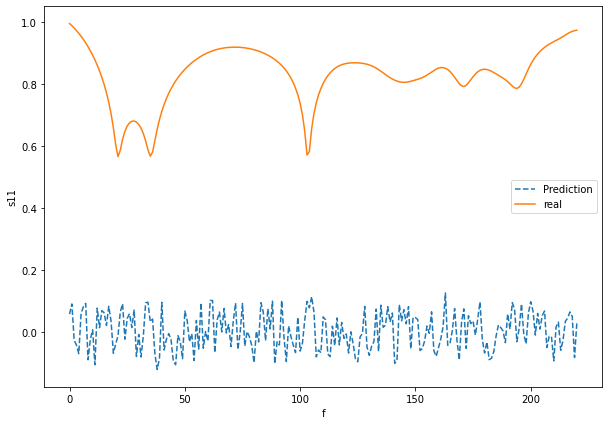

In [37]:
i = 100
x_ver = Variable(torch.from_numpy(X_ver))
x_ver = x_ver.float()
y_ver = Variable(torch.from_numpy(Y_ver))
y_ver = y_ver.float()
r=x_ver[i].unsqueeze(0)
r = r.permute(0,2,1)
predicted1 = model_dict(r.to(device))
predicted1 = predicted1.detach().cpu().numpy()
b=predicted1.squeeze(0)
fig, ax = plt.subplots(figsize = (10, 7))
#plt.scatter(X[: ,12],predicted1)
ax.plot(b, label='Prediction', linestyle = '--')
ax.plot(y_ver[i], label='real', linestyle = '-')
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('s11')

In [22]:
def fan_minmaxscaler(x,df):
    min = np.amin(df)
    max = np.amax(df)    
    return x*(max-min)+ min

In [23]:
e = fan_minmaxscaler(y_ver[i],Y)
a = fan_minmaxscaler(b,Y)

Text(0, 0.5, 's11')

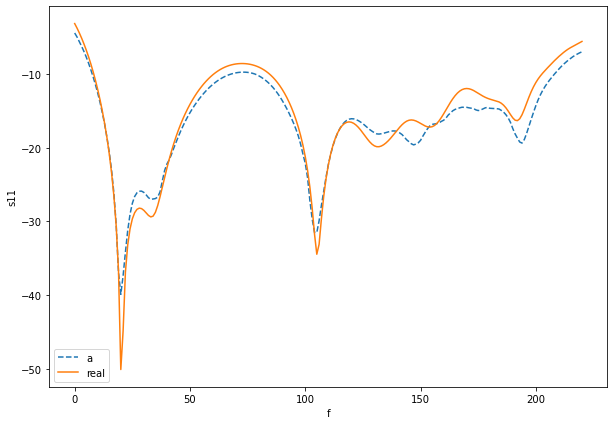

In [24]:
fig, ax = plt.subplots(figsize = (10, 7))

ax.plot(a, label='a', linestyle = '--')
ax.plot(e, label='real', linestyle = '-')
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('s11')

In [25]:
test=pd.DataFrame(data=a)
test.to_csv('./cnn1d_predicted1.csv',encoding='gbk')
test=pd.DataFrame(data=e)
test.to_csv('./cnn_real.csv',encoding='gbk')

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(8, 1000),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            
            torch.nn.Linear(1000, 800),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(800, 600),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(600, 500),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 300),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 250),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 221)

        )

        # init

    def forward(self, x):
        x = self.mlp(x)
        return x
model_dict=torch.load("MLP.pth")

In [30]:
X_ver_mlp = minmaxscaler(X1)[337,]
Y_ver_mlp = minmaxscaler(Y)[337,]

x_ver_mlp = torch.from_numpy(X_ver_mlp)
x_ver_mlp = x_ver_mlp.float()
y_ver_mlp = torch.from_numpy(Y_ver_mlp)
y_ver_mlp = y_ver_mlp.float()


Text(0, 0.5, 's11')

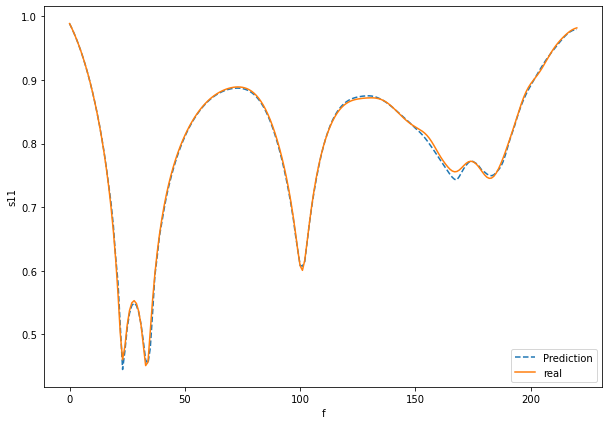

In [31]:
predicted1 = model_dict(x_ver_mlp)
predicted1 = predicted1.detach().numpy()
fig, ax = plt.subplots(figsize = (10, 7))
#plt.scatter(x_ver[: ,2],predicted1)
#plt.scatter(x_ver[: ,2],y_ver)
ax.plot(predicted1, label='Prediction', linestyle = '--')
ax.plot(y_ver_mlp, label='real', linestyle = '-')
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('s11')
#print(predicted1)

In [25]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(8, 1000),
            torch.nn.Sigmoid(),
            torch.nn.Linear(1000, 500),
            torch.nn.Sigmoid(),
            torch.nn.Linear(500, 221)
        )

        # init

    def forward(self, x):
        x = self.mlp(x)
        return x

In [26]:
model_dict_ANN=torch.load("ANN.pth")

Text(0, 0.5, 's11')

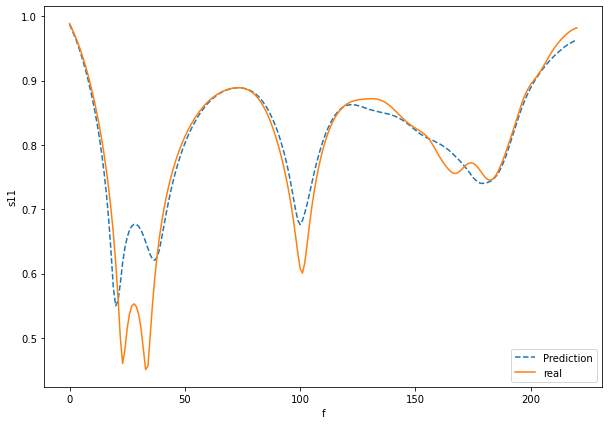

In [27]:
predicted2 = model_dict_ANN(x_ver_mlp)
predicted2 = predicted2.detach().numpy()
fig, ax = plt.subplots(figsize = (10, 7))
#plt.scatter(x_ver[: ,2],predicted1)
#plt.scatter(x_ver[: ,2],y_ver)
ax.plot(predicted2, label='Prediction', linestyle = '--')
ax.plot(y_ver_mlp, label='real', linestyle = '-')
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('s11')
#print(predicted1)